# Bank Credit
adrianty & sondrewo

## Table of contents:

* [Implicit assumptions and discussion](#implicit_assumptions)
* [Model Development](#model_dev)
    * [Hypothesis and heuristics](#hypothesis)
    * [Exp 1: Comparing different classification models](#comparing_different)    
        - [Estimating actual performance of MultinomialNB](#actual_performance)
    * [Exp 2: Feature Selection](#feature_selection)
    * [Exp 3: Comparison with RandomBanker.py](#comparison) 
* [Fairness](#fairness)
* [Reproducibility and reliability](#reproduce)
* [Privacy](#privacy)


   

## Implicit assumptions of the data <a id="implicit_assumptions"></a>

The data was already labeled with some named columns in the provided TestLending script. We still decided to do some explorative testing, to see if we could use some heuristics to develop some additional understanding of the data. We found out that there were many more elements that were labelled with <em>2</em>, which is described in the documentation as <em>bad</em>, than there were those that were labelled with <em>1</em>, or <em>good</em>. Further inspection revealed that the average amount for the <em>bad</em> loans were quite a lot higher than the <em>good</em> ones. This could suggest that the data is taken from a position in time where the <em>bad</em> loans have already defaulted, and the <em>good</em> ones are in the process of being paid off.

This of course would make modelling extremely difficult, as we would have to normalize the amounts for the duration remaining. This would be extremely speculative and probably not make for good generalization, so we make the assumption that this is not the case, and that the duration and amount listed are initial values.

## Model development <a id="model_dev"></a>

## Intro <a id="hypothesis"></a>

We started our model development by inspecting the different columns in the data set, identifying both numerical and discrete  features. As is well known, the Naive Bayes classifier supports catergorical features natively and can be adjusted to use numerical ones as well. Thus, we formulated the following hypothesis:

<strong>H</strong><sub>0</sub> : The Multinomial Naive Bayes classifier will provide a high accuracy

We then attempted to falsify this hypothesis (Exp 1) by testing out different models: Logistic regression, KNN, BernoulliNB, AdaBoost with Decision Tree and a simple multi-layered perceptron (MLP).

## Setup

In [1]:
class AdrianSondreBanker:
    def __init__(self, MODEL):
        self.model = MODEL
    
    def fit(self, X, y):
        self.data = [X, y]
        self.model.fit(X, y)

    def set_interest_rate(self, rate):
        self.rate = rate
        return

    def predict_proba(self, x):
        """
        Gets the probability distribution over two classes. 
        Reshape is done to get the result as a simple 1d array.
        """
        return self.model.predict_proba(np.array(x).reshape(1, -1))[0]

    def expected_utility(self, x, action):
        """
        Calculates the expected utility of an individual. Uses the formula
        
        utility = amount_of_loan * (1 + lend_rate)^duration_of_loan
        """
        utility = x["amount"] * ((1 + self.rate) ** x['duration'])
        
        # Generate a utility matrix for the loan.
        # will look like this for a utility of 100 for a loan of 20:
        
        #                    ___________________
        #                   |will pay | wont pay|
        # ------------------|---------|---------|
        # dont give loan    |    0    |    0    |
        #-------------------|---------|---------|
        # do give loan      |   100   |  - 20   |
        #----------------------------------------
        U = np.matrix(f"0 0; {utility} {x['amount'] * -1}")

        # get the probabilities of the classes (will pay, wont pay)
        probs = self.predict_proba(x)
        
        # get the index of the highest probability - 0 if wont pay, 1 if will pay
        repaid = np.where(probs == max(probs))

        return U[action, repaid]

    def get_best_action(self, x):
        """
        Decide whether to give a loan to some individual x.
        
        Returns:
            the index of the highest expected utility - 0 if loan denied, 1 if loan given
        """
        util = [self.expected_utility(x, a) for a in [0,1]]
        return util.index(max(util))

In [2]:
from sklearn.naive_bayes import MultinomialNB 
from sklearn.naive_bayes import BernoulliNB 
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
import pandas
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import random_banker
%matplotlib inline

In [3]:
VALID_PATH = "./data/credit/D_valid.csv"
TRAIN_PATH = "./data/credit/D_train.csv"
TEST_PATH = "./data/credit/D_test.csv"
interest_rate = 0.017

def get_data(path):
    """
    Fetches a dataset with the desirable features. Discussion on the 
    different datasets can be found below.
    """
    features = ['checking account balance', 'duration', 'credit history',
                'purpose', 'amount', 'savings', 'employment', 'installment',
                'marital status', 'other debtors', 'residence time',
                'property', 'age', 'other installments', 'housing', 'credits',
                'job', 'persons', 'phone', 'foreign']
    target = 'repaid'

    df = pandas.read_csv(path, sep=' ',
                         names=features+[target])
    numerical_features = ['duration', 'age', 'residence time', 'installment', 'amount', 'persons', 'credits']
    quantitative_features = list(filter(lambda x: x not in numerical_features, features))
    X = pandas.get_dummies(df, columns=quantitative_features, drop_first=True)
    encoded_features = list(filter(lambda x: x != target, X.columns))
    return X, encoded_features, target

In [4]:
def test_decision_maker(X_test, y_test, interest_rate, decision_maker):
    """
    Default standard test - copied from TestLending.py
    """
    n_test_examples = len(X_test)
    utility = 0

    ## Example test function - this is only an unbiased test if the data has not been seen in training
    total_amount = 0
    total_utility = 0
    decision_maker.set_interest_rate(interest_rate)
    for t in range(n_test_examples):
        action = decision_maker.get_best_action(X_test.iloc[t])
        good_loan = y_test.iloc[t] # assume the labels are correct
        duration = X_test['duration'].iloc[t]
        amount = X_test['amount'].iloc[t]
        # If we don't grant the loan then nothing happens
        if (action==1):
            if (good_loan != 1):
                utility -= amount
            else:
                utility += amount*(pow(1 + interest_rate, duration) - 1)
        total_utility += utility
        total_amount += amount
    return utility, total_utility/total_amount

In [5]:
### Do a number of preliminary tests by splitting the data in parts
def run_test(models, X, encoded_features, target):
    '''
    Default testing of a (or multiple) model(s), mostly taken from TestLending.py
    
    args:
        models (dict): dictionary of models to test on. key=str (name of model), value=model
    returns:
        results: dictionary of the total utility and avg investment return per n, per model
    '''
    results = {}
    n_tests = 100
    for name, model in models.items():
        decision_maker = AdrianSondreBanker(model)
        utility = 0
        investment_return = 0
        for iter in range(n_tests):
            X_train, X_test, y_train, y_test = train_test_split(X[encoded_features], X[target], test_size=0.2)
            decision_maker.set_interest_rate(interest_rate)
            decision_maker.fit(X_train, y_train)
            Ui, Ri = test_decision_maker(X_test[encoded_features], y_test, interest_rate, decision_maker)
            utility += Ui
            investment_return += Ri
        results[name] = [math.floor((utility / n_tests) * 100)/100.0, math.floor((investment_return / n_tests) * 100)/100.0]
    return results, decision_maker

## Exp 1: Comparing different classification models: <a id="comparing_different"></a>

In [6]:
def run_tests_for_all_classifiers():
    """
    Compare results from different classifiers, using the default test above.
    """
    X, encoded_f, tar = get_data("./data/credit/D_valid.csv")
    results = run_test({"KNN": KNeighborsClassifier(n_neighbors=31),
                    "BernoulliNB": BernoulliNB(),
                    "MultinomialNB": MultinomialNB(),
                    "Log.regression": LogisticRegression(max_iter=1500),
                    "Neural Net": MLPClassifier(alpha=1, max_iter=1000)}, X, encoded_f, tar)
    return pandas.DataFrame(results[0].items(), columns=["Model", "Total Utility, Avg Investment Return"])

In [7]:
run_tests_for_all_classifiers()

,Model,"Total Utility, Avg Investment Return"
0,KNN,"[389729.9, 9.53]"
1,BernoulliNB,"[2086286.11, 51.14]"
2,MultinomialNB,"[4300184.95, 113.95]"
3,Log.regression,"[1502540.78, 39.68]"
4,Neural Net,"[855499.33, 22.68]"


### Results of Exp 1:

Based on these results, we chose to keep our hypothesis H<sub>0</sub> and continue the development using the Multinomial NB model as a baseline.

<b> Assumption 1 </b>: 
    Since the results for Multinomial NB was that much better than for KNN, we assumed that changing the amount of neighbours would not out-perform NB and decided to only test for `k=floor(sqrt(n))=31` (a common approach for K selection for KNN)


## Estimating actual performance of Multinomial Naive Bayes <a id="actual_performance"></a>

It seems that Multinomial Naive Bayes is the best technique for modelling this dataset. But to get a better understanding of the span of the model, we visualize it by resampling the data retrieved from n iterations of training and testing.

In [75]:
def avg_for_n_runs(X, n, encoded_features, target):
    """
    Compact function that fetches utility scores and averages for n runs.
    """
    utis, avg = [], []
    for _ in range(n):
        X_tr, X_te, y_tr, y_te = train_test_split(X[encoded_features], X[target], test_size=0.2)
        banker = AdrianSondreBanker(MultinomialNB())
        banker.fit(X_tr, y_tr)
        uti, div = test_decision_maker(X_te, y_te, interest_rate, banker)
        utis.append(uti)
        avg.append(div)
    return utis, avg

We have experimented with both the provided D_valid and D_train datasets, as they have quite different content. in the D_valid set, about 1/3 of the individuals are granted a loan, while in D_train, about 2/3 are. We are leaving the D_test set untill we feel like we are completely finished with the model development, so that we have some fundament to evaluate how well our model can generalize.

In [8]:
from sklearn.utils import resample

In [9]:
def get_samples(dataset, info=None):
    """
    Helper function to fetch resampling of a set of results. 
    
    Args:
        dataset (str): the name of the dataset.
        info (tuple): A tuple of a dataset, features, and the target value name
    Returns:
        a list of averages of resampled results.
    """
    if not info:
        X, encoded_f, tar = get_data(f"./data/credit/D_{dataset}.csv")
    else:
        X, encoded_f, tar = info
    n = 500
    m_uti, m_avg = avg_for_n_runs(X, n, encoded_f, tar)
    m_uti = np.array(m_uti)
    return [resample(m_uti).sum()/n for _ in range(10000)]

In [10]:
def create_hist_for_valid():
    """
    Create a histogram for the D_valid dataset.
    """
    data = [round(x/1000000,3) for x in get_samples("valid")]
    plt.hist(data, bins=20)
    plt.xlabel('utility')
    plt.ylabel('count')
    plt.title('Histogram of utilities - D_valid')

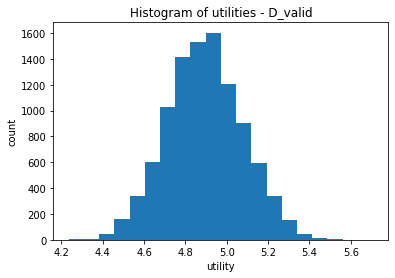

In [20]:
create_hist_for_valid()

A histogram of the total utility of our model over 500 runs, resampled 1000 times. The model is trained on the D_valid data set. There is a clear gaussian tendency of the data, with the average being around 4.8 million.

In [11]:
def create_hist_for_train():
    """
    Create a histogram for the D_train dataset.
    """
    data = [round(x/1000000, 3) for x in get_samples("train")]
    plt.hist(data, bins=20)
    plt.xlabel("utility")
    plt.ylabel("count")
    plt.title("Histogram of utilities - D_train")

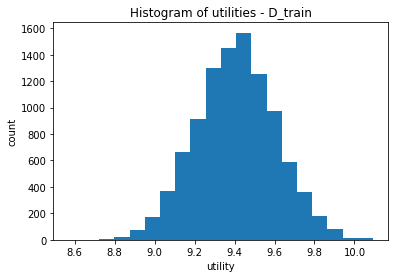

In [22]:
create_hist_for_train()

A histogram like the one above, but on the D_train set The same tendencies can be found, but the numbers are likely different due to the one above due to the difference in class distributions - but we will put this to the test in the next section.

In [12]:
def create_hist_for_both():
    """
    Create a histogram for both the D_valid and D_train datasets.
    """
    X, encoded_f, tar = get_data(VALID_PATH)
    X_t, _, _ = get_data(TRAIN_PATH)
    X = pandas.concat([X, X_t])
    data = get_samples("", info=(X, encoded_f, tar))
    plt.hist(data, bins=20)
    plt.xlabel("utility")
    plt.ylabel("count")
    plt.title("Histogram of utilities - both sets")

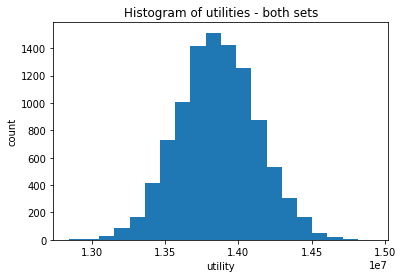

In [24]:
create_hist_for_both()

We see that the utility is increasing proportionally with the size of the dataset, meaning that the model likely does not benefit from the extra data. This might be because some of the features we are using are diffusing the generalization process. We will explore that in the following section.

## Exp 2:  Feature selection <a id="feature_selection"></a>

Next, we decided to try forward stepwise feature selection, based on the lab session by Dirk Hesse, using the baseline model.

In [13]:
from sklearn.model_selection import cross_val_score
from random import sample

### Feature Selection

In [14]:
def stepwise_selection(features, target, classifier=MultinomialNB()): #Credit: Dirk's notebooks
    """
    Extract the best 0 > N > 12 features from the dataset.
    
    Args:
        features (pandas DataFrame): The dataset
        target (str): The target column of the dataset
        classifier (sklearn model): some classifier
    Returns:
        a list of the best scores, and a list of the best features.
    
    """
    global_best_features = []
    global_best_scores = []
    global_best_score = pandas.Series([0])
    for N in range(1, 12):
        columns = list(filter(lambda x: x != "repaid", features.columns))
        columns = sample(columns, len(columns))
        selected_features = []
        scores = []
        while len(selected_features) < N:
            best_score = pandas.Series([0])
            best_feature = None
            for feature in columns:
                score = cross_val_score(classifier,
                                       features[selected_features + [feature]], features[target])
                if score.mean() > best_score.mean():
                    best_feature = feature
                    best_score = score
            columns.remove(best_feature)
            selected_features.append(best_feature)
            scores.append(best_score)
        best_scores = list(sorted(scores, reverse=True, key=lambda x: x.mean()))[0]
        if np.array(best_scores).mean() > np.array(global_best_score).mean():
            global_best_features = selected_features 
            global_best_score = np.array(scores).mean()
        global_best_scores.append(best_scores)
    return global_best_scores, global_best_features

In [15]:
def create_hist_for_stepwise(path=VALID_PATH):
    """
    Create a histogram using the stepwise function.
    """
    if isinstance(path, str):
        X, encoded_f, tar = get_data(path)
    elif isinstance(path, bool):
        X, encoded_f, tar = get_data(VALID_PATH)
        X_t, _, _ = get_data(TRAIN_PATH)
        X = pandas.concat([X, X_t])
    scores, selected_features = stepwise_selection(X, tar)
    if "amount" not in selected_features:
        selected_features = selected_features + ["amount"]
    if "duration" not in selected_features:
        selected_features = selected_features + ["duration"]
    data = get_samples("", info=(X, selected_features, tar))
    data = [round(x/1000000,3) for x in data]
    plt.hist(data, bins=20)
    plt.xlabel("utility")
    plt.ylabel("count")
    plt.title("Histogram with selected features")
    return scores, selected_features

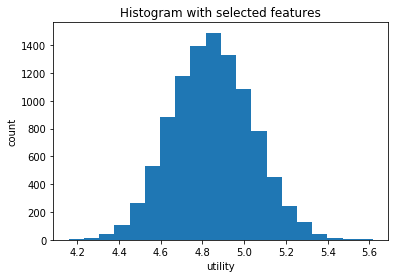

In [87]:
scores, selected_features = create_hist_for_stepwise()

The fewer selected features have seemingly little effect on the valid dataset, as the numbers are very similar to the above figure.

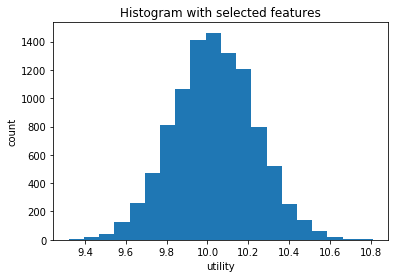

In [88]:
train_scores, train_selected_features = create_hist_for_stepwise(path=TRAIN_PATH)

These values however are distinguishly higher than before. Using the train dataset, it would seem that higher utility is achievable by removing some of the features.

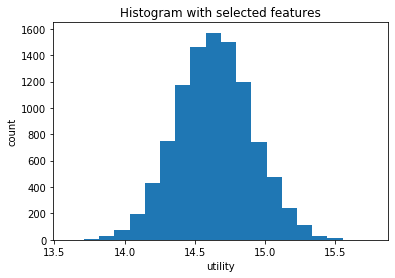

In [89]:
both_scores, both_selected_Features = create_hist_for_stepwise(path=True)

We see that the values for both sets are very similar for both sets, albeit more concentrated around the average. It is clear that there is little extra information to extract by using both datasets.

We can plot some graphs to visualize how the model behaves when trained on different datasets:

#### FIG 1 <a id="fig_1"></a>

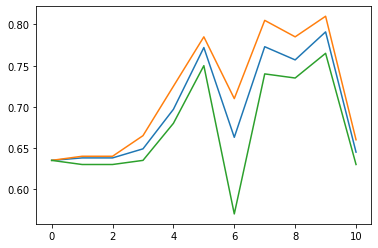

In [90]:
# VALID SET
plt.plot([s.mean() for s in scores])
plt.plot([s.max() for s in scores])
plt.plot([s.min() for s in scores])

#### FIG 2 <a id="fig_2"></a>

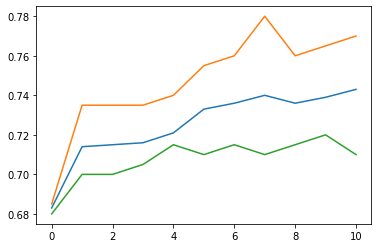

In [91]:
# TRAIN SET
plt.plot([s.mean() for s in train_scores])
plt.plot([s.max() for s in train_scores])
plt.plot([s.min() for s in train_scores])

#### FIG 3 <a id="fig_3"></a>

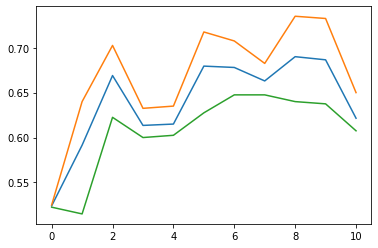

In [92]:
# BOTH SETS
plt.plot([s.mean() for s in both_scores])
plt.plot([s.max() for s in both_scores])
plt.plot([s.min() for s in both_scores])

### Results of Exp 2:

We can see that the model is behaving differently to different amounts of features, but for most the differences between >4 and <10 are not really indicative of anything - possibly except for the model trained on the D_train-dataset in [Fig 2](#fig_2). Which is interesting, considering that it was the only model that performed better with fewer parameters. There might be a sweet spot beyond the values we tested for.

## Exp 3: Comparison with RandomBanker.py <a id="comparison"></a>

In [16]:
def run_test_single_model(X, features, target, maker):
    res = []
    decision_maker = maker
    utility = 0
    investment_return = 0
    n_tests = 100
    for iter in range(n_tests):
        X_train, X_test, y_train, y_test = train_test_split(X[features], X[target], test_size=0.2)
        decision_maker.set_interest_rate(interest_rate)
        decision_maker.fit(X_train, y_train)
        Ui, Ri = test_decision_maker(X_test, y_test, interest_rate, decision_maker)
        utility += Ui
        investment_return += Ri
    
    res.append(math.floor((utility / n_tests) * 100)/100.0)
    res.append(math.floor((investment_return / n_tests) * 100)/100.0)
    return res

In [17]:
def compare_models():
    comp_test = {}
    for i in ["train", "valid", "both"]:
        if i == "train":
            X, features, tar = get_data(TRAIN_PATH)
        elif i == "valid":
            X, features, tar = get_data(VALID_PATH)
        else:
            X, features, tar = get_data(VALID_PATH)
            X_t, _, _ = get_data(TRAIN_PATH)
            X = pandas.concat([X, X_t])
        comp_test[f"Random banker_{i}"] = run_test_single_model(X, features, tar, random_banker.RandomBanker())
        comp_test[f"AdrianSondreBanker_{i}"] = run_test_single_model(X, features, tar, AdrianSondreBanker(MultinomialNB()))
    return pandas.DataFrame(comp_test.items(), columns=["Model", "Total Utility, Avg Investment Return"])

In [108]:
compare_models()

,Model,"Total Utility, Avg Investment Return"
0,Random banker_train,"[5274903.98, 136.48]"
1,AdrianSondreBanker_train,"[9912512.82, 251.25]"
2,Random banker_valid,"[1160487.92, 31.09]"
3,AdrianSondreBanker_valid,"[5303397.49, 133.8]"
4,Random banker_both,"[6210055.6, 143.96]"
5,AdrianSondreBanker_both,"[13330336.86, 321.0]"


### Results of Exp 3

The table above shows that our model performed better than the random banker module by quite a substantial amount.

# PART 2 & 3

In [277]:
def get_df_with_gender(df):
    #male = 0, female = 1
    df["gender"] = np.where((df["marital status_2"] + df["marital status_5"] == 1), 1, 0)
    return df

def get_over_age(df):
    #over = 1, under = 0
    df["over60"] = np.where((df["age"] >= 60), 1, 0)
    return df

In [278]:
#Creating some baselines to use in this section
X, encoded_features, target = get_data(TRAIN_PATH)
X = get_df_with_gender(X)
X = get_over_age(X)
X_train, X_test, y_train, y_test = train_test_split(X, X[target], test_size=0.2)
model = MultinomialNB() #use our baseline
model.fit(X_train, y_train)
None

## Fairness <a id="fairness"></a>

As can be seen from the bar charts below, the data is highly skewed towards males and foreign workers. Most of the individuals are also between 20 and 40 years old.

### Descriptives

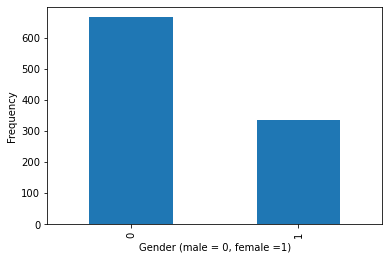

In [279]:
ax = X['gender'].value_counts().plot.bar()
ax.set_xlabel("Gender (male = 0, female =1)")
ax.set_ylabel("Frequency")
None

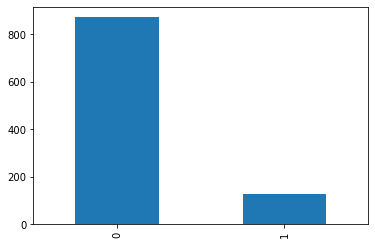

In [280]:
ax = X['over60'].value_counts().plot.bar()

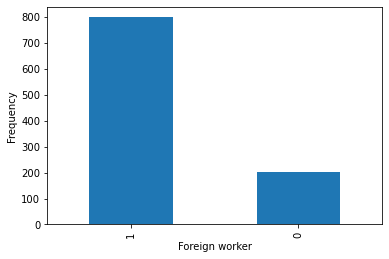

In [281]:
ax = X['foreign_2'].value_counts().plot.bar()
ax.set_xlabel("Foreign worker")
ax.set_ylabel("Frequency")
None

### P-percent metric

We wanted to quantitatively measure fairness in our model. One way to do that is through the p-percent metric (Zafar et.al, 2017):

$$ p\%score=min ( \frac{𝑃(𝑦̂ =1|𝑧=1)}{𝑃(𝑦̂ =1|𝑧=0)}, \frac{𝑃(𝑦̂ =1|𝑧=0)}{𝑃(𝑦̂ =1|𝑧=1)})$$ 

The method gives us a measure on the demographic parity of our model. We want the rate of positive outcomes to be equal for some protected/sensitive feautres, like gender and ethinicity, or in our case: foreign worker status. As seen below, when checking for the foreign worker feature in our training set, we get consistent p%-scores over 80%. So what does this mean? According to Zafar et.al (2017), we can say that the score satisifes the criterion of disparate treatment if the ratio between the percentage of applicants with the foreign worker attribute being granted a loan and the percentage of
non-foreign workers being granted a loan is no less than 80:100, which holds. The table below calculates the p-percent score for gender, foreign worker status and age(over 60), both deemed as sensitive and both of which has a skewed distribution in the data.


In [282]:
from sklego.metrics import p_percent_score

In [283]:
def get_p_scores(features):
    res = {}
    for f in features:
        p = (p_percent_score(sensitive_column=f)(model, X))
        res[str(f)] = p
    return res

### Exp 1: P-Percent score for Foreign worker status, gender and age

In [284]:
res = get_p_scores(["foreign_2","gender", "over60"])
df = pandas.DataFrame(res.items(), columns=["Feature", "P-score"])
df

,Feature,P-score
0,foreign_2,0.933807
1,gender,0.950722
2,over60,0.744538


### Exp 1 Results:

AGE DISCRIMINATION!!! :(((

## Reproducibility and reliability <a id="reproduce"></a>

We have used multiple datasets in our modelling. It can be useful to see the differences in these datasets when trying to generalize from them. They are quite different, most significantly in the class distribution (in our code the classes (1,2) are converted to classes (1,2)):

| Class | D_train | D_valid |
|-------|---------|---------|
|   1   |   683   |   365   |
|   2   |   317   |   635   |

The values are almost entirely inverted, but most of the other values stay relatively similar. For example, both the average amount values - 20348 in train vs 20643 in dev - are very similar. So are the numbers for average duration. 

For any model that allows us to generalize over new data, we have to make sacrifices in its reliability. The most prominent sacrifice in our best model, which is based on the Naive Bayes technique, is the precise fundament that allows for such a model. The core assumption of Naive Bayes is that the variables are independent, which obviously cannot hold for a datset like ours. What we do get from utilizing the technique is a very stable and reproducable model, that will generalize better (in the form of maximizing the utility, i.e. revenue) than the competing models - see results of above experiments.

That being said, reproducibility and reliability are not necessarily disjoint. There are several methods that improve both aspects. For example, a utilizing kfold will allow us to see if a part of the dataset is significantly structurally different than others, and thus stop the decision boundary of the model to become skewed, but it will also allow the model to see more data, improving the reliability. Data will always be both limited and biased in some way, and generalizing perfectly will never happen in an open world. If we think that the data is too limited to learn enough from, for example in the form of an underrepresented class, we can apply bootstrapping to generate some samples from the data of the samples that we do have to get a broader fundament.

As for the goal of our model, and managing the risks of it being wrong, we will have to make some assumptions. We can introduce some heuristics to make our model best fit the situation it will be used for. We can for example introduce a higher threshold for lending money, making the assumption that it is worse for a bank to lose money to someone who will default the loan, than to not make money from not lending to someone that would not have defaulted. We could implement such a threshold $\gamma$ by applying a softmax function (or simply utilizing a Naive Bayes model) to the result of the model, and deducting $\gamma$ from the likelyhood of the individual being classified as a valuable lender.

### Privacy <a id="privacy"></a>

Use of machine learning algorithms raises multiple privacy concerns. How can we protect the identity of the participants in the data sets we train our models on? In our case, we note that the original data is anonymised. However, it is our judgement that this data set may potentially be exploited in linkeage attacks. 
The dataset has features indicating a range of personal attributes per record; combining age, job status, foreign worker status and amound/duration may narrow a search substantially – making identification of individuals not unthinkable. 

<strong> In order to protect the identity of "our" participants, we here outline the development process of a general procedure: </strong>

### Step 1: Randomised Response mechanism

We here try to randomise the response for the feature "Repaid", as this feature could potentially incriminate an individual associated with a negative record. We start of by randomising the repaid column with a theta of `0.5`. We then present the mean of the actual values and the randomised values. After that, we show a histogram of different samples.

<strong> Obs: This is also greatly inspired by Dirk's lab sessions. </strong>

In [45]:
def randomized_response(a, theta=0.5):
    repaids = np.random.choice([True, False], len(a), p=(theta, 1-theta))
    response = a.copy()
    noise = np.random.choice([0, 1], len(a))
    response[~repaids] = noise[~repaids]
    return response

In [157]:
X, encoded_f, tar = get_data(VALID_PATH)
res = {}
data = np.asarray(X["repaid"])
# 2 == bad loan, 1 == good
data = np.where(data == 2, 0, 1)
res["actual"] = data.mean()
res["randomised"] = randomized_response(data).mean()

In [19]:
df = pandas.DataFrame(res.items(), columns=["Set", "Results"])
df

,Set,Results
0,actual,0.365
1,randomised,0.431


In [16]:
def gen_sample(p, n=1000):
    return np.random.choice([0, 1], 1000, p=(1-p, p))
def show_hists(p, theta):
    approx = [approx_p(gen_sample(p), theta) for _ in range(1000)]
    true_v = [gen_sample(p).mean() for _ in range(1000)]
    plt.hist(approx, bins=15, alpha=0.5, label="noisy dist")
    plt.hist(true_v, bins=15, alpha=0.5, label="actual dist")
    plt.legend()
def approx_p(sample, theta=0.5):
    return (randomized_response(sample, theta).mean() - (1-theta)*0.5)/theta

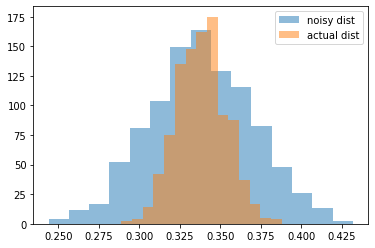

In [17]:
p = approx_p(data)
show_hists(p, 0.5)

As one can see from the histogram, having a randomised response mechanism creates some noise around values, and one gets a more spread distribution. However, the noisy and actual distributions both have similar averages. However, since our data is extremely sensitive to a false label due to the vast differences in potential utilities, even a few wrong labels might bring the classifier from good to terrible.

### Step 2:  Outline of a $\epsilon$ -DP rutine on the "repaid" column


The formula for any algorithm being differentially private:

$$\left|\log\frac{\pi(a, x)}{\pi(a, x')}\right| \leq \epsilon$$

In [119]:
data_reg = np.asarray(data[1:10])
data_prime = data_reg.copy()
data_prime[-1] = 1 if data_prime[-1] == 0 else 0

In [120]:
thetas = np.linspace(0.1, 0.5, 20)
ratios = [
    np.fromiter(((randomized_response(data_reg, theta) == data_reg).all() for _ in range(1000)), bool).mean() /
    np.fromiter(((randomized_response(data_prime, theta) == data_reg).all() for _ in range(1000)), bool).mean()
    for theta in thetas
]

In [121]:
%matplotlib inline

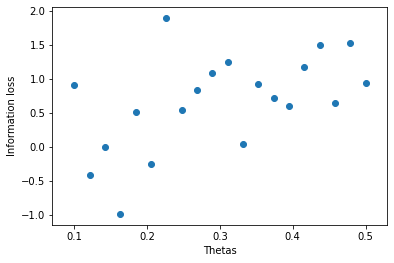

In [122]:
plt.scatter(thetas, np.log(ratios))
plt.xlabel("Thetas")
plt.ylabel("Information loss")
None

This is mostly doodling, as we have not been able to complete this section yet.

In [60]:
def distance_is_one(x, xp):
    """
    Function to measure distance between two rows in our dataset.
    """
    total_differences = 0
    for x_val, xp_val in zip(x.values, xp.values):
        if total_differences > 1:
            return False
        if x_val != xp_val:
            total_differences += 1
    return True

In [166]:
def cut_into_bins(X):
    """
    Categorizes the numerical columns in our dataset. 
    """
    numerical_features = ['duration', 'age', 'residence time', 'installment', 'amount', 'persons', 'credits']
    # bin sizes. Maybe we need to adjust bin sizes to generate neighbours
    bins = {
        "duration": 3,
        "age": 3,
        "residence time": 3,
        "amount": 3,
        "installment": 3,
        "persons": 3,
        "credits": 3
    }
    for feature in numerical_features:
        if feature not in bins:
            # probably small enough numbers to not bin
            continue
        X[feature] = pandas.cut(X[feature], bins[feature])
    return X

In [153]:
from itertools import combinations

In [173]:
def get_neighbours(X):
    """
    Generates combinations of all our rows, and 
    """
    X_binned = cut_into_bins(X)
    neighbours_precheck = combinations([x[1] for x in X_binned.iterrows()], 2)
    return [(x, xp) for x, xp in neighbours_precheck if distance_is_one(x, xp)]

In [174]:
X, _, _ = get_data(TRAIN_PATH)
neighbours = get_neighbours(X)

In [172]:
neighbours

[]

No neighbors. Our classifier is $\epsilon$-DP for any $\epsilon$. Fantastic!

Maybe we only need to check for neighbouring individuals in the case that some sensitive information is involved? 

# References

Zafar, M. B., Valera, I., Gomez-Rodriguez, M., & Gummadi, K. P. (2019). Fairness Constraints: A Flexible Approach for Fair Classification. J. Mach. Learn. Res., 20(75), 1-42.